# Imports, constants and functions

In [1]:
import os
import re
import nrrd
import numbers
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import pingouin as pg
import radiomics as pr
import SimpleITK as sitk
import matplotlib.pyplot as plt
import math
from radiomics import featureextractor
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy.ndimage import binary_dilation, binary_erosion
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Configura pandas para mostrar todo el DataFrame
pd.set_option('display.max_rows', None)      # Todas las filas
pd.set_option('display.max_columns', None)   # Todas las columnas
pd.set_option('display.width', None)         # Todo el ancho posible
pd.set_option('display.max_colwidth', None)  # Ancho completo del contenido de la columna

In [3]:
# Constantes
INPUT_PATH = '/Users/veramegias/Documents/Universidad/Cuarto/TFG/Segmentaciones'
IMAGES_PATH = 'images'
OUTPUT_PATH = 'outputs'
DATA_PATH = 'data'
REEXECUTE = True
MAX_NUM = 3

columns_file_text = f'{OUTPUT_PATH}/columnas_df_features.txt'

In [4]:
def preprocess_features(df, label_column, threshold_corr=0.95, threshold_var=0.01):
    """
    Preprocesa un DataFrame eliminando variables constantes, colineales y normalizando los datos.

    Pasos:
        1. Separa las variables independientes (X) y la variable objetivo (y).
        2. Elimina variables con baja varianza (prácticamente constantes).
        3. Elimina variables con alta correlación para reducir colinealidad.
        4. Normaliza las características con StandardScaler.

    Args:
        df (pd.DataFrame): DataFrame con las características radiómicas y la columna de la variable objetivo.
        label_column (str): Nombre de la columna que contiene la variable objetivo.
        threshold_corr (float): Umbral de correlación para eliminar variables (default 0.95).
        threshold_var (float): Umbral de varianza mínima para eliminar variables constantes (default 0.01).
    
    Returns:
        pd.DataFrame: DataFrame con las características preprocesadas, filtradas y normalizadas.
        pd.Series: Variable objetivo (y).
        list: Lista de variables eliminadas.
    """
    n_variables = len(df.columns)
    # 1. Separar la variable objetivo (y) de las características (X)
    X = df.drop(columns=[label_column])  # Todas las columnas excepto la de la etiqueta
    y = df[label_column]                 # Columna de la variable objetivo
    
    # 2. Eliminar variables con baja varianza
    var_selector = VarianceThreshold(threshold=threshold_var)
    X_var_filtered = pd.DataFrame(var_selector.fit_transform(X), columns=X.columns[var_selector.get_support()])
    removed_low_var = list(set(X.columns) - set(X_var_filtered.columns))
    
    print(f"Se eliminaron {len(removed_low_var)} variables con baja varianza.")

    # 3. Eliminar variables altamente correlacionadas
    corr_matrix = X_var_filtered.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold_corr)]
    
    X_filtered = X_var_filtered.drop(columns=to_drop)
    
    print(f"Se eliminaron {len(to_drop)} variables altamente correlacionadas.")

    # 4. Normalizar las características con StandardScaler y devolverlo como DataFrame
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered), columns=X_filtered.columns, index=X.index)
    
    print(f'Se han eliminado {len(removed_low_var + to_drop)} de {n_variables} variables')

    return X_scaled, y, removed_low_var + to_drop

In [5]:
def same_sizes(image1, image2):
    """
    Comprueba que la imagen 1 y la imagen 1 tienen las mismas dimensiones.
    
    Args:
        image1 (SimpleITK.Image): Imagen 1.
        image2 (SimpleITK.Image): Imagen 2.
    
    Returns:
        boolean: Si el tamaño coincide
    
    """
    return image1.GetSize() == image2.GetSize()

In [6]:
def simulate_resegmentation(mask, method, iterations):
    """
    Simula una segunda segmentación modificando la máscara original.
    
    Parámetros:
        mask (sitk.Image): Máscara original.
        method (str): 'dilation' o 'erosion'. Se usa para simular una resegmentación.
        iterations (int): Número de iteraciones de la operación morfológica.
    
    Retorna:
        sitk.Image: Máscara modificada.
    
    """
    mask_arr = sitk.GetArrayFromImage(mask)
    
    if method == 'dilation':
        #mask_arr_padded = np.pad(mask_arr, pad_width=1, mode='constant', constant_values=0)
        #mask_arr_padded_dil = binary_dilation(mask_arr_padded, structure=np.ones((3,3,3)), iterations=iterations)
        #mask_arr_mod = mask_arr_padded_dil[1:-1, 1:-1, 1:-1]
        mask_arr_mod = binary_dilation(mask_arr, structure=np.ones((3,3,3)), iterations=iterations)

        print("Antes:", mask_arr.sum())
        print("Después:", mask_arr_mod.sum())
        print("Size original:", mask_arr.shape)
        print("Size modificado:", mask_arr_mod.shape)
    elif method == 'erosion':
        mask_arr_mod = binary_erosion(mask_arr, structure=np.ones((3,3,3)), iterations=iterations)
        print("Antes:", mask_arr.sum())
        print("Después:", mask_arr_mod.sum())
    else:
        raise ValueError("El método debe ser 'dilation' o 'erosion'")
    
    mask_mod = sitk.GetImageFromArray(mask_arr_mod.astype(np.uint8))
    mask_mod.CopyInformation(mask)
    return mask_mod

In [7]:
def simulate_interpolation(image, new_spacing, method_interpol):
    """
    Re-muestrea la imagen a un espaciamiento ligeramente modificado.
    
    Parámetros:
        image (sitk.Image): Imagen original.
        new_spacing (tuple): Nuevo espaciamiento (por ejemplo, (sx, sy, sz)).
    
    Retorna:
        sitk.Image: Imagen re-muestreada.
    """
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    if method_interpol == "linear":
        resample.SetInterpolator(sitk.sitkLinear)
        new_image = resample.Execute(image)
    elif method_interpol == "B-Spline":
        resample.SetInterpolator(sitk.sitkBSpline)
        new_image = resample.Execute(image)
    else:
        print("[ERROR]  No valid interpolation method. Nothing applied.")
    
    return new_image

In [8]:
def simulate_interpolation_mask(mask, new_spacing):
    """
    Re-muestrea la máscara (usando interpolación de vecino más cercano) a un espaciamiento modificado.
    
    Parámetros:
        mask (sitk.Image): Máscara original.
        new_spacing (tuple): Nuevo espaciamiento.
    
    Retorna:
        sitk.Image: Máscara re-muestreada.
    
    """
    original_spacing = mask.GetSpacing()
    original_size = mask.GetSize()
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    resample.SetOutputDirection(mask.GetDirection())
    resample.SetOutputOrigin(mask.GetOrigin())
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    new_mask = resample.Execute(mask)
    return new_mask

In [ ]:
def evaluate_model(model, X_test, y_test, model_name, params):
    """
    Calcula métricas, muestra el reporte y dibuja CM y ROC.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"==> {model_name} {params}")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1 Score : {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, model_name, params)
    plot_roc_curve(y_test, y_prob, model_name, params)

In [60]:
def plot_confusion_matrix(cm, model_name, params, output_path='images'):
    """
    Dibuja y guarda la matriz de confusión.
    """
    os.makedirs(output_path, exist_ok=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}\n{params}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fname = f"cm_{model_name}_{abs(hash(frozenset(params.items())))}.png"
    plt.savefig(os.path.join(output_path, fname))
    plt.show()
    plt.close()

In [61]:
def plot_roc_curve(y_test, y_prob, model_name, params, output_path='images'):
    """
    Dibuja y guarda la curva ROC.
    """
    os.makedirs(output_path, exist_ok=True)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}\n{params}')
    plt.legend(loc='lower right')
    fname = f"roc_{model_name}_{abs(hash(frozenset(params.items())))}.png"
    plt.savefig(os.path.join(output_path, fname))
    plt.show()
    plt.close()

In [9]:
def get_features(image, mask):
    if same_sizes(image, mask):
        extractor = featureextractor.RadiomicsFeatureExtractor()
    else:
        print(f'[ERROR] Sizes are not the same.')
    features = extractor.execute(image, mask)
    
    return features

In [10]:
def extract_features(image_file_path, mask_file_path, process_type):
    """
    Extrae características radiómicas de una imagen y su máscara utilizando PyRadiomics.
    Args:
        image_file_path (str): Ruta al archivo NRRD que contiene la imagen a analizar.
        mask_file_path (str): Ruta al archivo NRRD que contiene la máscara asociada a la imagen.
    Returns:
        features (dict): Características radiómicas extraídas.
    Extra:
        Comprueba que el tamaño de las imagenes sea compatible.
    """
    # Load paths and images
    image_data, _ = nrrd.read(image_file_path)
    image = sitk.GetImageFromArray(image_data)
    mask_data, _ = nrrd.read(mask_file_path)
    mask = sitk.GetImageFromArray(mask_data)

    if process_type == "resegmentation_dil":
        mask = simulate_resegmentation(mask, method='dilation', iterations=1)
    elif process_type == "resegmentation_ero":
        mask = simulate_resegmentation(mask, method='erosion', iterations=1)
    elif process_type == "interpolation":
        original_spacing = image.GetSpacing()
        new_spacing = tuple([s + 0.1 for s in original_spacing])
        image = simulate_interpolation(image, new_spacing, 'linear')
        mask  = simulate_interpolation_mask(mask, new_spacing)
    elif process_type == "original":
        pass
    else:
        print("[ERROR]  No valid process. Nothing applied.")

    return get_features(image, mask)

In [11]:
def join_original_columns(df_original, df_interes):
    if len(df_original) != len(df_interes):
        raise ValueError("Los DataFrames tienen tamaños diferentes; no se pueden unir correctamente.")
    
    df_final = pd.concat([df_original.reset_index(drop=True), df_interes.reset_index(drop=True)], axis=1)

    return df_final

In [12]:
def compute_icc(df, feature_col, subject_col='subject', method_col='method'):
    """
    Calcula el ICC para una característica dada utilizando los modelos ICC2 e ICC3.
    
    Parámetros:
        df (pd.DataFrame): DataFrame con las mediciones.
        feature_col (str): Nombre de la columna que contiene la característica a evaluar.
        subject_col (str): Columna que identifica al sujeto.
        method_col (str): Columna que identifica el método o la medición.
    
    Retorna:
        dict: Diccionario con los valores de ICC2 e ICC3.
    """
    
    icc_df = pg.intraclass_corr(data=df, targets=feature_col, raters=method_col, ratings=subject_col)
    icc2 = icc_df.loc[icc_df['Type'] == 'ICC2', 'ICC'].values[0]
    icc3 = icc_df.loc[icc_df['Type'] == 'ICC3', 'ICC'].values[0]
    return {'ICC2': icc2, 'ICC3': icc3}

In [13]:
def convert_columns_to_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Dado un DataFrame, intenta convertir cada columna completa a tipo numérico.
    - Si un valor está dentro de un contenedor unitario (list, tuple, np.ndarray, pd.Series con un solo elemento),
      extrae ese elemento.
    - Maneja arrays numpy de 0 dimensiones (.ndim == 0) como escalares.
    - Si el valor resultante es un número, lo deja tal cual.
    - En otro caso, intenta hacer float(valor).
    - Si cualquier celda de la columna falla, imprime un mensaje y BORRA la columna entera.
    Devuelve un nuevo DataFrame con solo las columnas convertidas correctamente.
    """
    def _extraer_escalar(x):
        # numpy.ndarray de 0 dimensiones -> escalar
        if isinstance(x, np.ndarray):
            if x.ndim == 0:
                return x.item()
            if x.ndim == 1 and x.size == 1:
                return x[0]
            # arrays de mayor tamaño no se tratan como escalares
            return x
        # otros contenedores unitarios
        if isinstance(x, (list, tuple, pd.Series)) and len(x) == 1:
            return x[0]
        return x

    def _convertir_valor(x):
        x0 = _extraer_escalar(x)
        if isinstance(x0, numbers.Number):
            return x0
        try:
            return float(x0)
        except Exception:
            raise ValueError(f"No se pudo convertir el valor {x0!r} a número")

    df2 = df.copy()
    cols_a_eliminar = []
    for col in df2.columns:
        try:
            df2[col] = df2[col].apply(_convertir_valor)
        except Exception as e:
            print(f"Fallo en columna '{col}': {e}. Se eliminará la columna.")
            cols_a_eliminar.append(col)

    if cols_a_eliminar:
        df2.drop(columns=cols_a_eliminar, inplace=True)

    return df2

In [14]:
def plot_correlation_matrix(df: pd.DataFrame):
    """
    Mapa de calor de la matriz de correlación, sólo sobre columnas numéricas y no constantes.
    """
    num = df.select_dtypes(include=[np.number])
    num = num.loc[:, num.nunique() > 1]
    
    if num.shape[1] < 2:
        print("No hay suficientes variables numéricas variables para dibujar la matriz.")
        return
    corr = num.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', mask=mask, square=True)
    plt.title("Matriz de Correlación")
    plt.savefig(f'{IMAGES_PATH}/correlation_matrix.png')
    plt.show()
    plt.close()

In [15]:
def plot_variable_distribution(df: pd.DataFrame):
    nums = df.select_dtypes(include=[np.number]).columns
    for col in nums:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()
        plt.close()

In [16]:
def plot_lasso_path(X, y):
    """
    Genera un gráfico del camino de Lasso.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    y = y.values.ravel()
    print("Número de condición de X:", np.linalg.cond(X))
    alphas, coefs, _ = lasso_path(X_train_scaled, y, max_iter=10000, tol=1e-3)
    print("Condición de X (escalado):", np.linalg.cond(X_train_scaled))
    plt.figure(figsize=(10, 6))
    for coef in coefs:
        plt.plot(-np.log10(alphas), coef)
    
    plt.xlabel("-Log10(Alpha)")
    plt.ylabel("Coeficientes")
    plt.title("Lasso Path")
    plt.grid(True)
    plt.savefig(f'{IMAGES_PATH}/lasso_path.png')
    plt.show()


In [17]:
def plot_feature_importance(X, y, feature_names):
    """
    Importancia por RandomForest.
    """
    model = RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5)
    model.fit(X, y)
    importance = model.feature_importances_

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance)
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de las Características")
    plt.savefig(f'{IMAGES_PATH}/feature_importance_RF.png')
    plt.show()


In [18]:
def filter_columns_by_file(df, file_path):
    """
    Filtra las columnas del dataframe según un archivo con nombres de columnas
    seguidos de "OK" o "NO". Las columnas con "NO" se eliminan.
    """
    columns_to_keep = []

    with open(file_path, "r") as f:
        for line in f:
            column_info = line.strip().split()
            if len(column_info) == 2:  # Asegurarse de que hay un nombre y un estado
                column_name, status = column_info
                if status == "OK":
                    columns_to_keep.append(column_name)

    df_clean = df.copy()
    return df_clean[columns_to_keep]

In [19]:
def compute_icc(df, feature_col, subject_col='subject', method_col='method'):
    """
    Calcula el ICC para una característica dada utilizando ICC2 e ICC3.
    """
    icc_df = pg.intraclass_corr(
        data=df,
        targets=subject_col,
        raters=method_col,
        ratings=feature_col
    )
    icc2 = icc_df.loc[icc_df['Type'] == 'ICC2', 'ICC'].values[0]
    icc3 = icc_df.loc[icc_df['Type'] == 'ICC3', 'ICC'].values[0]
    return {'ICC2': icc2, 'ICC3': icc3}

In [20]:
def analyze_icc(df_original, df_reseg_dil, df_reseg_ero, df_interp):
    """
    Calcula el ICC por pares entre:
      - original vs. resegmentación dilatación
      - original vs. resegmentación erosión
      - original vs. interpolación
    """

    orig   = df_original.copy();   orig['method'] = 'original'
    reseg_dil  = df_reseg_dil.copy();      reseg_dil['method']  = 'reseg_dil'
    reseg_ero  = df_reseg_ero.copy();      reseg_ero['method']  = 'reseg_ero'
    interp = df_interp.copy();     interp['method'] = 'interp'

    features = [c for c in orig.columns if c not in ['subject', 'method']]

    results = {}
    for feat in features:
        # --- Original vs Resegmentación Dilatación---
        pair_reseg_dil = pd.concat([
            orig[['subject', 'method', feat]],
            reseg_dil[['subject', 'method', feat]]
        ], ignore_index=True)
        icc_vals_reseg_dil = compute_icc(pair_reseg_dil, feat, subject_col='subject', method_col='method')

        # --- Original vs Resegmentación Erosión---
        pair_reseg_ero = pd.concat([
            orig[['subject', 'method', feat]],
            reseg_ero[['subject', 'method', feat]]
        ], ignore_index=True)
        icc_vals_reseg_ero = compute_icc(pair_reseg_ero, feat, subject_col='subject', method_col='method')
        
        # --- Original vs Interpolación ---
        pair_interp = pd.concat([
            orig[['subject', 'method', feat]],
            interp[['subject', 'method', feat]]
        ], ignore_index=True)
        icc_vals_interp = compute_icc(pair_interp, feat, subject_col='subject', method_col='method')

        # Recoger en resultados
        results[feat] = {
            'ICC2_resegmentation_dil': icc_vals_reseg_dil['ICC2'],
            'ICC3_resegmentation_dil': icc_vals_reseg_dil['ICC3'],
            'ICC2_resegmentation_ero': icc_vals_reseg_ero['ICC2'],
            'ICC3_resegmentation_ero': icc_vals_reseg_ero['ICC3'],
            'ICC2_interpolation':  icc_vals_interp['ICC2'],
            'ICC3_interpolation':  icc_vals_interp['ICC3'],
        }

    return pd.DataFrame.from_dict(results, orient='index')

In [21]:
def filter_features_by_icc(
    df_original: pd.DataFrame,
    df_icc: pd.DataFrame,
    icc2_thresh_reseg_dil: float = 0.75,
    icc3_thresh_reseg_dil: float = 0.75,
    icc2_thresh_reseg_ero: float = 0.75,
    icc3_thresh_reseg_ero: float = 0.75,
    icc2_thresh_interp: float = 0.75,
    icc3_thresh_interp: float = 0.75
):
    """
    Filtra las columnas de df_original en dos nuevas tablas, 
    eliminando las features cuyo ICC está por debajo de los thresholds,
    por separado para resegmentación dilatación, resegmentación erosión e interpolación.

    Parámetros:
        df_original: DataFrame original con todas las features (más columnas
                     de identificación como 'subject', etc.).
        df_icc:      DataFrame con índice = nombre de feature, y columnas
                     'ICC2_reseg_dil', 'ICC3_reseg_dil', 'ICC2_reseg_ero', 'ICC3_reseg_ero', 'ICC2_interp', 'ICC3_interp'.
        icc2_thresh_reseg_dil:  umbral mínimo de ICC2 para reseg dil.
        icc3_thresh_reseg_dil:  umbral mínimo de ICC3 para reseg dil.
        icc2_thresh_reseg_ero:  umbral mínimo de ICC2 para reseg ero.
        icc3_thresh_reseg_ero:  umbral mínimo de ICC3 para reseg ero.
        icc2_thresh_interp: umbral mínimo de ICC2 para interp.
        icc3_thresh_interp: umbral mínimo de ICC3 para interp.

    Retorna:
        df_reseg_filtered_dil:   copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_reseg_dil AND 
                             ICC3>=icc3_thresh_reseg_dil.
        df_reseg_filtered_ero:   copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_reseg_ero AND 
                             ICC3>=icc3_thresh_reseg_ero.
        df_interp_filtered:  copia de df_original con sólo las features
                             que cumplen ICC2>=icc2_thresh_interp AND 
                             ICC3>=icc3_thresh_interp.
    """
    # 1) Comprobaciones básicas
    required_cols = {'ICC2_resegmentation_dil','ICC3_resegmentation_dil', 'ICC2_resegmentation_ero','ICC3_resegmentation_ero','ICC2_interpolation','ICC3_interpolation'}
    missing = required_cols - set(df_icc.columns)
    if missing:
        raise ValueError(f"df_icc no contiene columnas: {missing}")

    # 2) Crear máscaras para cada par
    mask_reseg_dil = (
        (df_icc['ICC2_resegmentation_dil']  >= icc2_thresh_reseg_dil) &
        (df_icc['ICC3_resegmentation_dil']  >= icc3_thresh_reseg_dil)
    )
    mask_reseg_ero = (
        (df_icc['ICC2_resegmentation_ero']  >= icc2_thresh_reseg_ero) &
        (df_icc['ICC3_resegmentation_ero']  >= icc3_thresh_reseg_ero)
    )
    mask_interp = (
        (df_icc['ICC2_interpolation'] >= icc2_thresh_interp) &
        (df_icc['ICC3_interpolation'] >= icc3_thresh_interp)
    )

    feats_reseg_dil  = df_icc.index[mask_reseg_dil].tolist()
    feats_reseg_ero  = df_icc.index[mask_reseg_ero].tolist()
    feats_interp = df_icc.index[mask_interp].tolist()

    # 3) Columnas del original que no son features
    non_feat_cols = [c for c in df_original.columns if c not in df_icc.index]

    # 4) Construcción de los DataFrames filtrados
    df_reseg_filtered_dil  = df_original[ non_feat_cols + feats_reseg_dil ].copy()
    df_reseg_filtered_ero  = df_original[ non_feat_cols + feats_reseg_ero ].copy()
    df_interp_filtered = df_original[ non_feat_cols + feats_interp ].copy()

    return df_reseg_filtered_dil, df_reseg_filtered_ero, df_interp_filtered

# Load data

In [22]:
# Para cambiar los nombres de los ficheros series, ejecutar en terminal en la carpeta de inputs:
# for file in series*.nrrd; do mv "$file" "${file/series/serie}"; done

In [23]:
if REEXECUTE:
    df_features = pd.DataFrame()

    for num in range(1,MAX_NUM):
        for extension in ['oc', 'ccr']:
            if (num == 36 or num == 42) and extension == 'oc':  # Excluir el fichero 36oc y 42oc
                continue
            print(f'Executing {num} for {extension}')
            image_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
            mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')
            
            if not os.path.exists(image_path):
                print(f'ERROR: No such file for {image_path}')
            if not os.path.exists(mask_path):
                print(f'ERROR: No such file for {mask_path}')

            features_image = extract_features(image_path, mask_path, "original")
            features_image['cancer'] = 'ccr' in mask_path
            features_image['method'] = "original"
            features_image['subject'] = str(num)
            df_features.to_csv('prueba.csv')
            df_features = pd.concat([df_features, pd.DataFrame([features_image])], ignore_index=True)
            df_features.to_csv('prueba2.csv')
            exit(1)
            exit(1)
    df_features.to_csv('df_features.csv', index=False)
else:
    df_features = pd.read_csv('df_features.csv')

Executing 1 for oc


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Executing 1 for ccr


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Executing 2 for oc


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Executing 2 for ccr


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [24]:
if REEXECUTE:
    df_features_reseg_dil = pd.DataFrame()
    df_features_reseg_ero = pd.DataFrame()
    df_features_interp = pd.DataFrame()

    for num in range(1,MAX_NUM):
        for extension in ['oc', 'ccr']:
            if (num == 36 or num == 42) and extension == 'oc':  # Excluir el fichero 36oc y 42oc
                continue
            print(f'Executing {num} for {extension}')
            image_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, 'serie'+str(num)+extension+'.nrrd')
            mask_path = os.path.join(INPUT_PATH, extension, str(num)+extension, 'Seg'+str(num)+extension, extension+str(num)+'.nrrd')

            if not os.path.exists(image_path):
                print(f'ERROR: No such file for {image_path}')
            if not os.path.exists(mask_path):
                print(f'ERROR: No such file for {mask_path}')
            
            features_reseg_dil = extract_features(image_path, mask_path, "resegmentation_dil")
            features_reseg_ero = extract_features(image_path, mask_path, "resegmentation_ero")
            features_interp = extract_features(image_path, mask_path, "interpolation")
            features_reseg_dil['cancer'] = 'ccr' in mask_path
            features_reseg_ero['cancer'] = 'ccr' in mask_path
            features_interp['cancer'] = 'ccr' in mask_path
            features_reseg_dil['subject'] = str(num)
            features_reseg_ero['subject'] = str(num)
            features_interp['subject'] = str(num)
            features_reseg_dil['method'] = "resegmentation_dil"
            features_reseg_ero['method'] = "resegmentation_ero"
            features_interp['method'] = "interpolation"
            df_features_reseg_dil = pd.concat([df_features_reseg_dil, pd.DataFrame([features_reseg_dil])], ignore_index=True)
            df_features_reseg_ero = pd.concat([df_features_reseg_ero, pd.DataFrame([features_reseg_ero])], ignore_index=True)
            df_features_interp = pd.concat([df_features_interp, pd.DataFrame([features_interp])], ignore_index=True)
        
    df_features_reseg_dil.to_csv('df_features_reseg_dil.csv', index=False)
    df_features_reseg_ero.to_csv('df_features_reseg_ero.csv', index=False)
    df_features_interp.to_csv('df_features_interp.csv', index=False)

else:
    df_features_reseg_dil = pd.read_csv('df_features_reseg_dil.csv')
    df_features_reseg_ero = pd.read_csv('df_features_reseg_ero.csv')
    df_features_interp = pd.read_csv('df_features_interp.csv')

Executing 1 for oc
Antes: 435
Después: 1182
Size original: (512, 512, 107)
Size modificado: (512, 512, 107)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Antes: 435
Después: 40


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Executing 1 for ccr
Antes: 28612
Después: 36169
Size original: (512, 512, 342)
Size modificado: (512, 512, 342)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Antes: 28612
Después: 21990


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Executing 2 for oc
Antes: 3023
Después: 4963
Size original: (512, 512, 302)
Size modificado: (512, 512, 302)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Antes: 3023
Después: 1594


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Executing 2 for ccr
Antes: 82250
Después: 97110
Size original: (512, 512, 276)
Size modificado: (512, 512, 276)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Antes: 82250
Después: 68744


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [25]:
print(len(df_features.columns))
print(len(df_features_reseg_dil.columns))
print(len(df_features_reseg_ero.columns))
print(len(df_features_interp.columns))

132
132
132
132


# Clean dataframe

In [26]:
if False:
    with open(f'{columns_file_text}', "w") as f:
        for column in df_features.columns:
            f.write(column + " OK \n")

In [27]:
def funcion_prueba(df_init):
    # Creacion de la columna subject con el digito de cancer
    df = df_init.copy()
    df['aux'] = (df['cancer'] != False).astype(int)
    df['subject_aux'] = df['subject'].astype(str) + df['aux'].astype(str)
    df['subject'] = df['subject_aux'].astype(int)
    try:
        df = df.drop('aux', axis=1)
        df = df.drop('cancer', axis=1)
        df = df.drop('subject_aux', axis=1)
    except:
        pass
    return df

In [28]:
columns_to_keep = ['method', 'subject']

In [29]:
df_features = funcion_prueba(df_features)
saved_columns = df_features[columns_to_keep].copy()
df_clean = filter_columns_by_file(df_features, columns_file_text)
print(len(df_clean.columns))
df_clean = convert_columns_to_numeric(df_clean)
print(len(df_clean.columns))
df_clean.drop(columns=columns_to_keep, errors='ignore')
df_clean = pd.concat([saved_columns, df_clean], axis=1)

124
Fallo en columna 'diagnostics_Image-original_Hash': No se pudo convertir el valor '8d7665c7a69d5330cb6330fd4c3f96d74645bec8' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Dimensionality': No se pudo convertir el valor '3D' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Spacing': No se pudo convertir el valor (1.0, 1.0, 1.0) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Size': No se pudo convertir el valor (107, 512, 512) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Hash': No se pudo convertir el valor 'f25e0799ebb7f98db98942f3b4633f507c4bd94c' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Spacing': No se pudo convertir el valor (1.0, 1.0, 1.0) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Size': No se pudo convertir el valor (107, 512, 512) a número. Se eliminará la columna.
Fallo en 

In [30]:
df_features_reseg_dil = funcion_prueba(df_features_reseg_dil)

saved_columns_reseg = df_features_reseg_dil[columns_to_keep].copy()
df_reseg_clean_dil = filter_columns_by_file(df_features_reseg_dil, columns_file_text)
df_reseg_clean_dil = convert_columns_to_numeric(df_reseg_clean_dil)
print(len(df_reseg_clean_dil.columns))
df_reseg_clean_dil.drop(columns=columns_to_keep, errors='ignore')
print(len(df_reseg_clean_dil.columns))
df_reseg_clean_dil = pd.concat([saved_columns_reseg, df_reseg_clean_dil], axis=1)
print(len(df_reseg_clean_dil.columns))

Fallo en columna 'diagnostics_Image-original_Hash': No se pudo convertir el valor '8d7665c7a69d5330cb6330fd4c3f96d74645bec8' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Dimensionality': No se pudo convertir el valor '3D' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Spacing': No se pudo convertir el valor (1.0, 1.0, 1.0) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Size': No se pudo convertir el valor (107, 512, 512) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Hash': No se pudo convertir el valor '834bd4abe914527b30f10ff1835657065ab749ce' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Spacing': No se pudo convertir el valor (1.0, 1.0, 1.0) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Size': No se pudo convertir el valor (107, 512, 512) a número. Se eliminará la columna.
Fallo en colu

In [31]:
df_features_reseg_ero = funcion_prueba(df_features_reseg_ero)

saved_columns_reseg = df_features_reseg_ero[columns_to_keep].copy()
df_reseg_clean_ero = filter_columns_by_file(df_features_reseg_ero, columns_file_text)
df_reseg_clean_ero = convert_columns_to_numeric(df_reseg_clean_ero)
df_reseg_clean_ero.drop(columns=columns_to_keep, errors='ignore')
df_reseg_clean_ero = pd.concat([saved_columns_reseg, df_reseg_clean_ero], axis=1)

Fallo en columna 'diagnostics_Image-original_Hash': No se pudo convertir el valor '8d7665c7a69d5330cb6330fd4c3f96d74645bec8' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Dimensionality': No se pudo convertir el valor '3D' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Spacing': No se pudo convertir el valor (1.0, 1.0, 1.0) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Size': No se pudo convertir el valor (107, 512, 512) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Hash': No se pudo convertir el valor '75dc6b4447e6dc58ce337f39bb003dddc538d16b' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Spacing': No se pudo convertir el valor (1.0, 1.0, 1.0) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Size': No se pudo convertir el valor (107, 512, 512) a número. Se eliminará la columna.
Fallo en colu

In [32]:
df_features_interp = funcion_prueba(df_features_interp)

saved_columns_reseg = df_features_interp[columns_to_keep].copy()
df_interp_clean = filter_columns_by_file(df_features_interp, columns_file_text)
df_interp_clean = convert_columns_to_numeric(df_interp_clean)
df_interp_clean.drop(columns=columns_to_keep, errors='ignore')
df_interp_clean = pd.concat([saved_columns_reseg, df_interp_clean], axis=1)

Fallo en columna 'diagnostics_Image-original_Hash': No se pudo convertir el valor '22306f8e3250cbef2654674b50944564d5039315' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Dimensionality': No se pudo convertir el valor '3D' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Spacing': No se pudo convertir el valor (1.1, 1.1, 1.1) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Image-original_Size': No se pudo convertir el valor (97, 465, 465) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Hash': No se pudo convertir el valor '0a13f36dcba5229a4cf1c63ac6366b8e2a2240c9' a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Spacing': No se pudo convertir el valor (1.1, 1.1, 1.1) a número. Se eliminará la columna.
Fallo en columna 'diagnostics_Mask-original_Size': No se pudo convertir el valor (97, 465, 465) a número. Se eliminará la columna.
Fallo en column

In [33]:
df_clean.to_csv('df_clean.csv', index=False)
df_reseg_clean_dil.to_csv('df_reseg_clean_dil.csv', index=False)
df_reseg_clean_ero.to_csv('df_reseg_clean_ero.csv', index=False)
df_interp_clean.to_csv('df_interp_clean.csv', index=False)

In [34]:
# --- Comparar encabezados ---
cols1 = set(df_clean.columns)
cols2 = set(df_features.columns)

faltan_en_df1 = cols2 - cols1      # están en df2 pero no en df1
faltan_en_df2 = cols1 - cols2      # están en df1 pero no en df2

print("En df2 y no en df1:", faltan_en_df1)
print("En df1 y no en df2:", faltan_en_df2)

En df2 y no en df1: {'diagnostics_Versions_Python', 'diagnostics_Image-original_Size', 'diagnostics_Versions_PyWavelet', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Versions_SimpleITK', 'diagnostics_Mask-original_Spacing', 'diagnostics_Configuration_Settings', 'diagnostics_Versions_PyRadiomics', 'diagnostics_Mask-original_CenterOfMass', 'diagnostics_Versions_Numpy', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Mask-original_Size'}
En df1 y no en df2: set()


# ICC process

In [35]:
df_reseg_clean_dil

,method,subject,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject
0,resegmentation_dil,10,-614.391324,-1024.0,2778.0,1182,1,0.946261,0.307992,5.495701,17.843662,19.104973,19.646883,18.110770,19.748418,1166.583333,16.884761,0.711371,753.353198,0.645777,1182.0,-80.0,175.0,20807130.0,3.327308,111.5,2.994182,217.0,76.166651,94.006768,134.0,-153.0

In [36]:
df_reseg_clean_dil['subject']

,subject,subject
0,10,10
1,11,11
2,20,20
3,21,21


In [37]:
mask_orig = np.ones(df_clean.shape[1], dtype=bool)  # vector de True del tamaño de tus columnas
mask_orig[1] = False                                # marcamos False la posición que queremos quitar
df_clean = df_clean.iloc[:, mask_orig]

mask_dil = np.ones(df_reseg_clean_dil.shape[1], dtype=bool)  # vector de True del tamaño de tus columnas
mask_dil[1] = False                                          # marcamos False la posición que queremos quitar
df_reseg_clean_dil = df_reseg_clean_dil.iloc[:, mask_dil]

mask_ero = np.ones(df_reseg_clean_ero.shape[1], dtype=bool)  # vector de True del tamaño de tus columnas
mask_ero[1] = False                                          # marcamos False la posición que queremos quitar
df_reseg_clean_ero = df_reseg_clean_ero.iloc[:, mask_ero]

mask_interp = np.ones(df_interp_clean.shape[1], dtype=bool)  # vector de True del tamaño de tus columnas
mask_interp[1] = False                                       # marcamos False la posición que queremos quitar
df_interp_clean = df_interp_clean.iloc[:, mask_interp]

In [38]:
df_clean

,method,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject
0,original,-614.391324,-1024.0,2778.0,435,1,0.929791,0.222162,3.235708,14.564623,17.000000,17.262677,16.000000,17.262677,422.500000,13.542060,0.563530,483.190076,1.143645,435.0,74.4,165.0,7238905.0,2.495008,41.0,4.553240,202.0,28.191592,123.294253,131.0,-10.0,212.0,17.581442,129.000624

In [39]:
df_reseg_clean_dil

,method,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject
0,resegmentation_dil,-614.391324,-1024.0,2778.0,1182,1,0.946261,0.307992,5.495701,17.843662,19.104973,19.646883,18.110770,19.748418,1166.583333,16.884761,0.711371,753.353198,0.645777,1182.0,-80.0,175.0,20807130.0,3.327308,111.5,2.994182,217.0,76.166651,94.006768,134.0,-153.0,370.0,52.4

In [40]:
df_reseg_clean_dil['subject']

0    10
1    11
2    20
3    21
Name: subject, dtype: int64

In [41]:
results_icc = analyze_icc(df_clean, df_reseg_clean_dil, df_reseg_clean_ero, df_interp_clean)
print("Resultados del ICC para cada característica:")

/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/parametric.py:1008: RuntimeWarning: divide by zero encountered in scalar divide
  fval = msbetween / mserror
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:320: RuntimeWarning: divide by zero encountered in scalar divide
  f1k = msb / msw
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:325: RuntimeWarning: divide by zero encountered in scalar divide
  f2k = f3k = msb / mse
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:354: RuntimeWarning: invalid value encountered in scalar divide
  l1 = (f1l - 1) / (f1l + (k - 1))
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:355: RuntimeWarning: invalid value encountered in scalar divide
  u1 = (f1u - 1) / (f1u + (k - 1))
/Users/veramegias/anaconda3/lib/python3.11/site-packages/pingouin/reliability.py:358: RuntimeWarning: invalid value encountered in 

Resultados del ICC para cada característica:


In [42]:
results_icc

,ICC2_resegmentation_dil,ICC3_resegmentation_dil,ICC2_resegmentation_ero,ICC3_resegmentation_ero,ICC2_interpolation,ICC3_interpolation
diagnostics_Image-original_Mean,1.000000,1.000000,1.000000,1.000000,0.999766,0.999999
diagnostics_Image-original_Minimum,NaN,NaN,NaN,NaN,NaN,NaN
diagnostics_Image-original_Maximum,1.000000,1.000000,1.000000,1.000000,0.666109,0.680527
diagnostics_Mask-original_VoxelNum,0.979483,0.987811,0.977056,0.985416,0.947712,0.959814
diagnostics_Mask-original_VolumeNum,NaN,NaN,NaN,NaN,NaN,NaN
original_shape_Elongation,0.948111,0.988236,-0.228288,-0.250737,0.982059,0.990883
original_shape_Flatness,0.950263,0.973115,0.939338,0.953608,0.991277,0.988518
original_shape_LeastAxisLength,0.984675,0.999984,0.984721,0.999981,0.999759,0.999682
original_shape_MajorAxisLength,0.990018,0.999945,0.987090,0.999541,0.999939,0.999941
original_shape_Maximum2DDiameterColumn,0.994960,0.999976,0.972154,0.988848,0.999909,0.999881


In [43]:
results_icc.to_csv('results_icc.csv', index=False)

In [44]:
def plot_histograms_grid(df, cols, bins=10, alpha=0.7, ncols=2, figsize=(10, 6)):
    """
    Dibuja histogramas individuales de las columnas especificadas en una única figura
    organizada en una rejilla de subplots.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame con las columnas a graficar.
    cols : list of str
        Lista de nombres de columnas de df cuyos histogramas quieres dibujar.
    bins : int, opcional
        Número de bins (intervalos) para cada histograma. Por defecto 10.
    alpha : float, opcional
        Transparencia de las barras. Por defecto 0.7.
    ncols : int, opcional
        Número de columnas de la rejilla de subplots. Por defecto 2.
    figsize : tuple, opcional
        Tamaño de la figura (ancho, alto). Por defecto (10, 6).
    """
    n_plots = len(cols)
    nrows = int(np.ceil(n_plots / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        ax.hist(df[col], bins=bins, alpha=alpha)
        ax.set_title(col)
        ax.set_xlabel('Valor ICC')
        ax.set_ylabel('Frecuencia')
        ax.grid(linestyle='--', alpha=0.3)

    # Desactivar ejes sobrantes si cols no llena toda la rejilla
    for ax in axes[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.savefig('histograms_icc.png')
    plt.show()
    

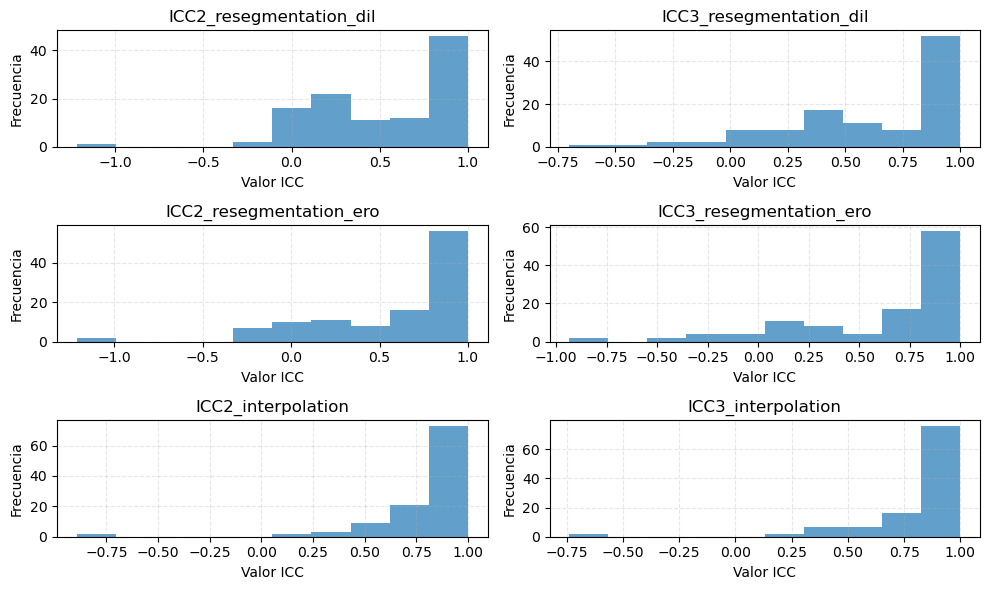

In [45]:
plot_histograms_grid(results_icc, ['ICC2_resegmentation_dil', 'ICC3_resegmentation_dil', 'ICC2_resegmentation_ero', 'ICC3_resegmentation_ero', 'ICC2_interpolation', 'ICC3_interpolation'])

In [71]:
ICC2_RESEG_DIL = 0.75
ICC3_RESEG_DIL = 0.75
ICC2_RESEG_ERO = 0.75
ICC3_RESEG_ERO = 0.75
ICC2_INTERP = 0.75
ICC3_INTERP = 0.75

df_filt_reseg_dil, df_filt_reseg_ero, df_filt_interp = filter_features_by_icc(df_clean, results_icc, ICC2_RESEG_DIL, ICC3_RESEG_DIL, ICC2_RESEG_ERO, ICC3_RESEG_ERO, ICC2_INTERP, ICC3_INTERP)

In [72]:
print(len(df_filt_reseg_dil.columns))

51


## See data for ML Algorithms

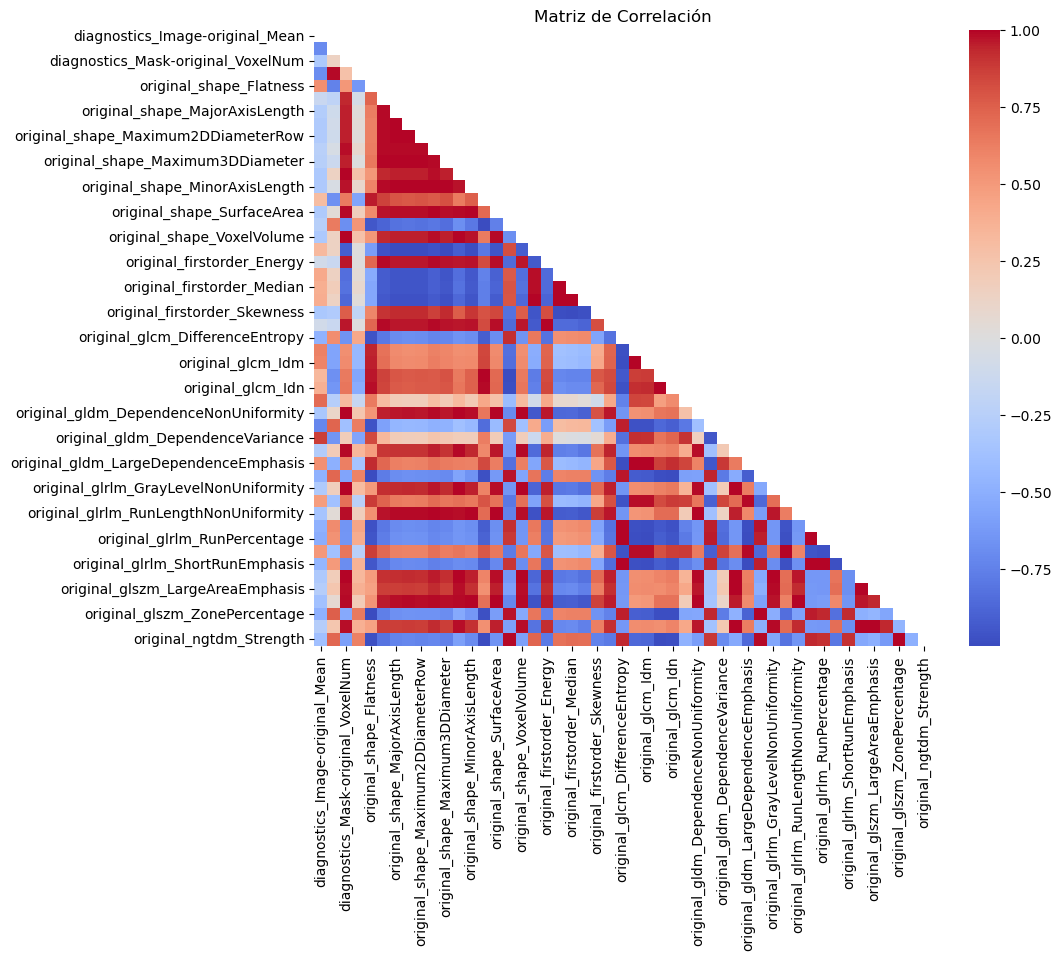

In [73]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_reseg_dil.drop(columns=['subject']))

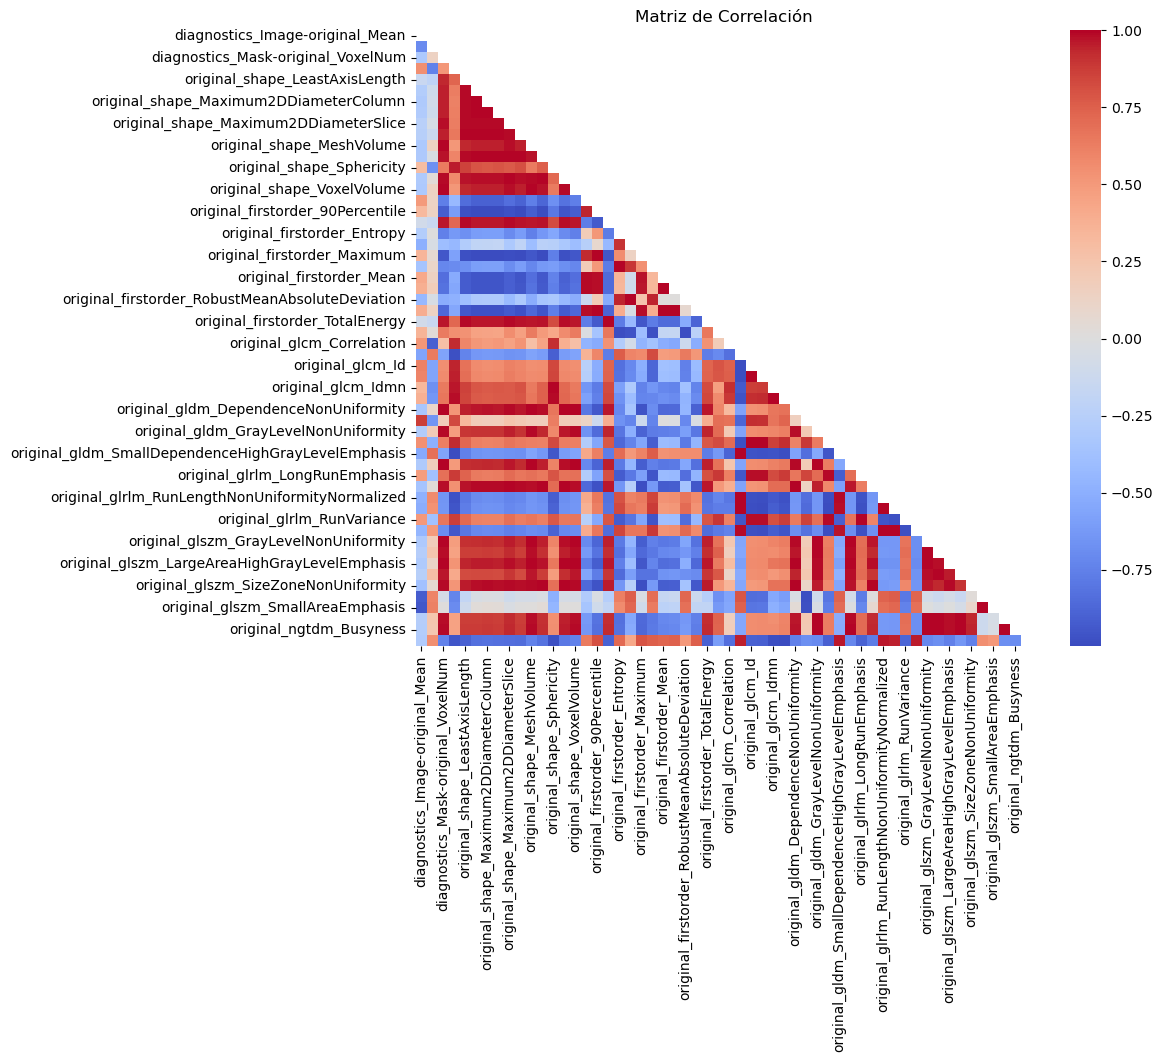

In [74]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_reseg_ero.drop(columns=['subject']))

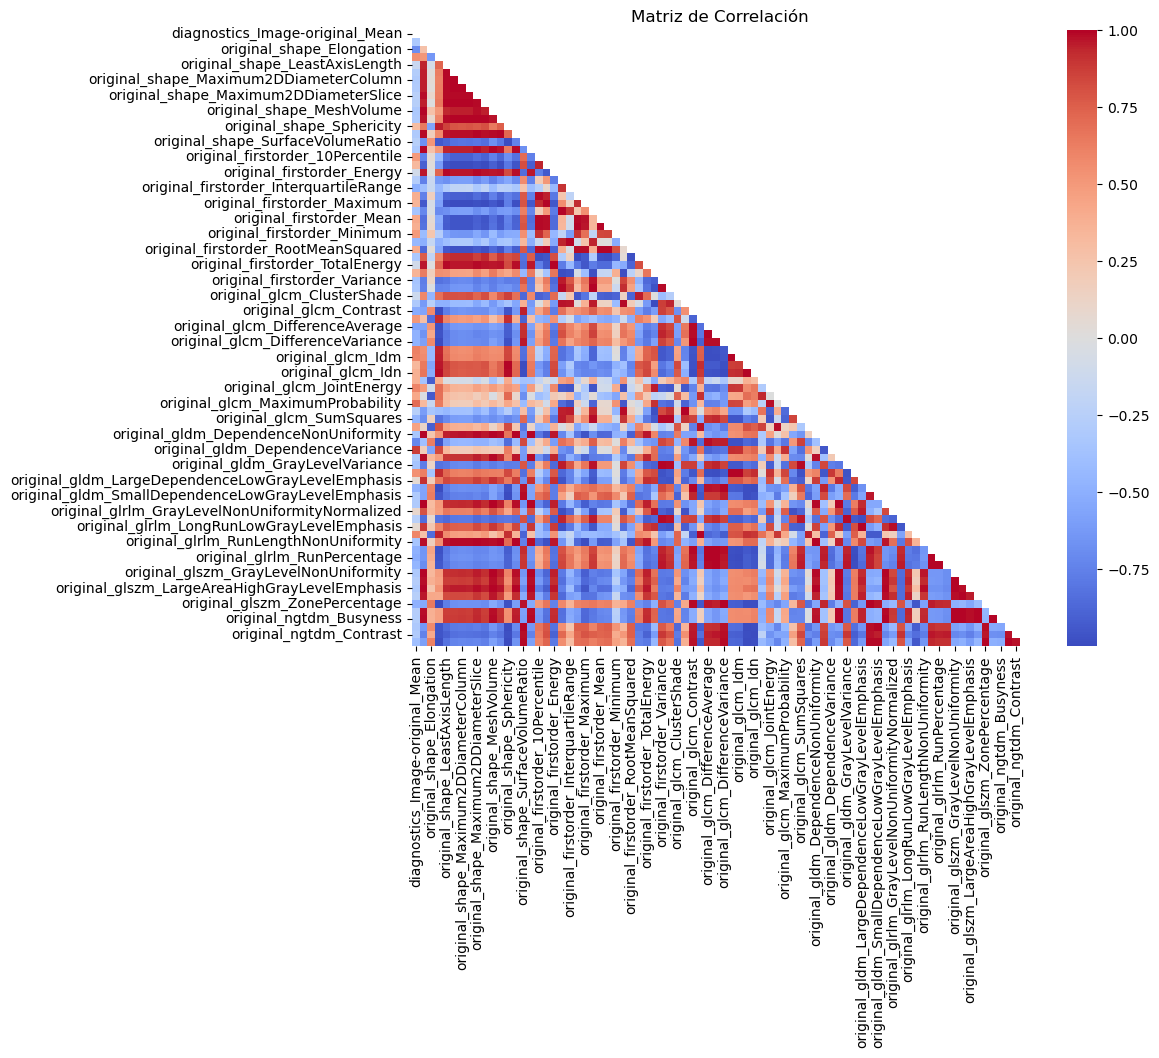

In [75]:
# CUIDADO: No se pintan todas las variables
plot_correlation_matrix(df_filt_interp.drop(columns=['subject']))

In [76]:
#plot_variable_distribution(df_filt_reseg_dil)

In [77]:
#plot_variable_distribution(df_filt_reseg_ero)

In [78]:
#plot_variable_distribution(df_filt_interp)

In [79]:
print(len(df_filt_reseg_dil.columns))

51


In [80]:
print(len(df_filt_reseg_ero.columns))

58


In [81]:
# Pre-process for ML Algorithms

# Crea columna 'cancer' usando la columna 'subject'. True si subject acaba en 1, false si subject acaba en 0.
df_filt_reseg_dil['cancer'] = df_filt_reseg_dil['subject'].astype(str).str.endswith('1')
df_filt_reseg_ero['cancer'] = df_filt_reseg_ero['subject'].astype(str).str.endswith('1')
df_filt_interp['cancer'] = df_filt_interp['subject'].astype(str).str.endswith('1')

# Eliminar columna method.
df_filt_reseg_dil.drop('method', axis=1, inplace=True)
df_filt_reseg_ero.drop('method', axis=1, inplace=True)
df_filt_interp.drop('method', axis=1, inplace=True)

In [82]:
from typing import Tuple

def filter_df1_by_common(df1: pd.DataFrame,
                         df2: pd.DataFrame,
                         df3: pd.DataFrame,
                         df4: pd.DataFrame) -> pd.DataFrame:
    """
    Recibe cuatro DataFrames y devuelve una copia de df1 filtrada
    para conservar únicamente las columnas que están en común
    entre df2, df3 y df4 (y que existan también en df1).

    - Calcula la intersección de columnas entre df2, df3 y df4.
    - Filtra df1 dejando solo aquellas columnas que también estén en esa intersección.
    - Si no hay columnas en común, devuelve un DataFrame vacío (con índice de df1).
    """
    # Conjuntos de columnas de df2, df3, df4
    cols2 = set(df2.columns)
    cols3 = set(df3.columns)
    cols4 = set(df4.columns)
    
    # Columnas comunes a df2, df3 y df4
    common_234 = cols2 & cols3 & cols4
    
    # De las columnas comunes, quedarnos solo con las que también están en df1
    cols_to_keep = [col for col in df1.columns if col in common_234]
    
    # Devolver copia filtrada de df1
    return df1.loc[:, cols_to_keep].copy()

In [83]:
df_machine_learning = filter_df1_by_common(df_clean, df_filt_reseg_dil, df_filt_reseg_ero, df_filt_interp)

In [ ]:
df_machine_learning['cancer']
# Revisar como se hace la columna "cancer" en df_filt_* y hacerlo en df_clean

KeyError: 'cancer'

In [ ]:
X_reseg, y_reseg, removed_reseg_dil = preprocess_features(df_machine_learning, 'cancer')

# ML Algorithms

In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, classification_report
)

In [ ]:
# models = {
#         'DecisionTree': {
#             'model': DecisionTreeClassifier(random_state=0),
#             'params': {
#                 'max_depth': [5],
#                 'min_samples_split': [2]
#             }
#         },
#         'RandomForest': {
#             'model': RandomForestClassifier(random_state=0),
#             'params': {
#                 'n_estimators': [100],
#                 'max_depth': [5]
#             }
#         },
#         'GradientBoosting': {
#             'model': GradientBoostingClassifier(random_state=0),
#             'params': {
#                 'n_estimators': [100],
#                 'learning_rate': [0.1]
#             }
#         },
#         'KNN': {
#             'model': KNeighborsClassifier(),
#             'params': {
#                 'n_neighbors': [3],
#                 'weights': ['uniform']
#             }
#         }
#     }

In [ ]:
models = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=0),
            'params': {
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5]
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=0),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [None, 5, 10]
            }
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=0),
            'params': {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance']
            }
        }
    }

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reseg, y_reseg, test_size=0.2, random_state=42, stratify=y_reseg)

for name, cfg in models.items():
    base = cfg['model']
    for params in ParameterGrid(cfg['params']):
        print(f"Training {name} with {params}")
        model = base.set_params(**params)
        model.fit(X_train.to_numpy(), y_train.to_numpy())
        evaluate_model(model, X_test.to_numpy(), y_test.to_numpy(), name, params)